In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances
import numpy as onp
import jax
import jax.numpy as np
from jax import jit, vmap
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as t
from ipywidgets import interact
from jax import grad
from jax.scipy.optimize import minimize
from jax import config
config.update("jax_enable_x64", True)
from jax.scipy.linalg import cholesky, cho_factor, cho_solve
from jax.scipy.optimize import minimize
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_box

import pandas as pd

In [26]:
Inputs = onp.load('../helmholtz_data/Helmholtz_inputs.npy')
Outputs = onp.load('../helmholtz_data/Helmholtz_outputs.npy')

In [27]:
Inputs = Inputs.transpose((2,1,0))
Outputs = Outputs.transpose((2,1,0))

Inputs_fl = Inputs.reshape(len(Inputs), 101*101)
Outputs_fl = Outputs.reshape(len(Outputs), 101*101)

In [28]:
Ntrain = 1000

In [29]:
Xtr = Inputs_fl[:Ntrain]


In [30]:
%%time
pca = PCA(n_components=20)
Xtr = pca.fit_transform(Xtr)

CPU times: user 2.03 s, sys: 211 ms, total: 2.25 s
Wall time: 705 ms


In [31]:
Xtest = pca.transform(Inputs_fl[Ntrain:])
Ytr = Outputs_fl[:Ntrain]
Ytest = Outputs_fl[Ntrain:]


In [32]:
def sqeuclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sum( (x - y) ** 2)
dists = jit(vmap(vmap(sqeuclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))

def euclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.sum( (x - y) ** 2))
sqdists = jit(vmap(vmap(euclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))


@jit
def matern(v1, v2, sigma = 50):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = sqdists(v1, v2)
    #return a*np.exp(-d**2/sigma)
    return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)

@jit
def exp(v1, v2, sigma):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = dists(v1, v2)
    return np.exp(-d/sigma)
    #return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)

@jit
def iq(v1, v2, sigma):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = dists(v1, v2)
    #return a*np.exp(-d**2/sigma)
    #return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)
    return 1/np.sqrt(d+sigma)

In [33]:
nugget = 1e-8

In [34]:
def aux(kernel, s, nugget):
    k = kernel
    Kxx = k(Xtr, Xtr, s)
    nuggeted_matrix = Kxx.at[np.diag_indices_from(Kxx)].add(nugget)
    L = cho_factor(nuggeted_matrix)
    result = cho_solve(L, Ytr)
    Train_pred = Kxx@result #train predictions
    K_te_tr = k(Xtest, Xtr, s)
    Test_pred = K_te_tr@result #test predictions

    print(Test_pred.shape)
    print(Ytest.shape)

    np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))

    aux1 = np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))
    aux2 = np.mean(np.linalg.norm(Train_pred-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
    aux3 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1))
    aux4 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1)/np.linalg.norm(Ytest, axis = 1))

    print(s, nugget)
    print("\n Train error (abs): {0} \n Train error (rel): {1} \n Test error (abs): {2} \n Test error (rel): {3}".format(aux1, aux2, aux3, aux4))
    print('---')

In [35]:
for kernel in [matern]:
    for s in [600, 700, 800, 900, 1000]:
        for nugget in [1e-8]:
            aux(kernel, s, nugget)

(39500, 10201)
(39500, 10201)
600 1e-08

 Train error (abs): 0.06734173344485452 
 Train error (rel): 0.0580156706026171 
 Test error (abs): 0.11575476568237457 
 Test error (rel): 0.09818617707540477
---
(39500, 10201)
(39500, 10201)
700 1e-08

 Train error (abs): 0.07401547738097886 
 Train error (rel): 0.06349995908063123 
 Test error (abs): 0.11343090079632341 
 Test error (rel): 0.09609963285838599
---
(39500, 10201)
(39500, 10201)
800 1e-08

 Train error (abs): 0.07918275696751266 
 Train error (rel): 0.0677111080178911 
 Test error (abs): 0.11231652688084894 
 Test error (rel): 0.09503717803771658
---
(39500, 10201)
(39500, 10201)
900 1e-08

 Train error (abs): 0.08341732338158256 
 Train error (rel): 0.07113996231640249 
 Test error (abs): 0.11198238386880756 
 Test error (rel): 0.09463942825780988
---
(39500, 10201)
(39500, 10201)
1000 1e-08

 Train error (abs): 0.08708566153828005 
 Train error (rel): 0.07409329305439706 
 Test error (abs): 0.11218354355001159 
 Test error (r

: 

In [14]:
%%time
Kxx = iq(Xtr, Xtr, 1000)
nuggeted_matrix = Kxx.at[np.diag_indices_from(Kxx)].add(nugget)
L = cho_factor(nuggeted_matrix)
result = cho_solve(L, Ytr)
Train_pred = Kxx@result #train predictions
K_te_tr = iq(Xtest, Xtr,1000)
Test_pred = K_te_tr@result #test predictions


CPU times: user 45.5 s, sys: 5.41 s, total: 50.9 s
Wall time: 6.64 s


In [15]:
np.linalg.norm(Test_pred[41]-Ytest[41])/np.linalg.norm(Ytest[41])

Array(0.04875739, dtype=float64)

In [16]:
import pickle
pickle.dump(obj=[Ytest[41], Test_pred[41]], file = open('PredictedHH.pkl', 'wb'))

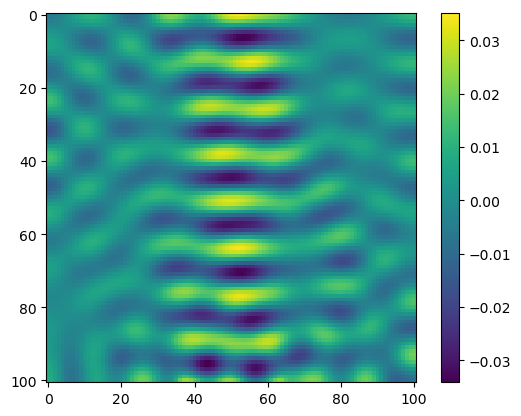

In [17]:
plt.imshow(Test_pred[41].reshape(101,101))
plt.colorbar()

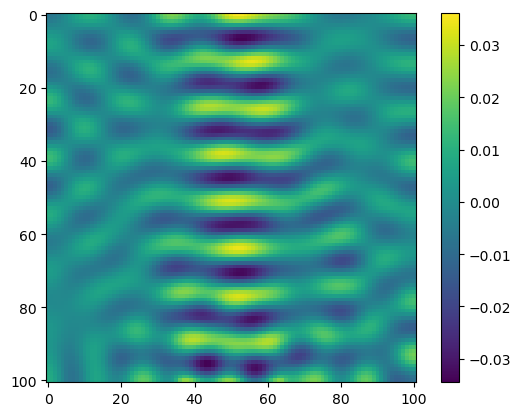

In [18]:
plt.imshow(Ytest[41].reshape(101,101))
plt.colorbar()

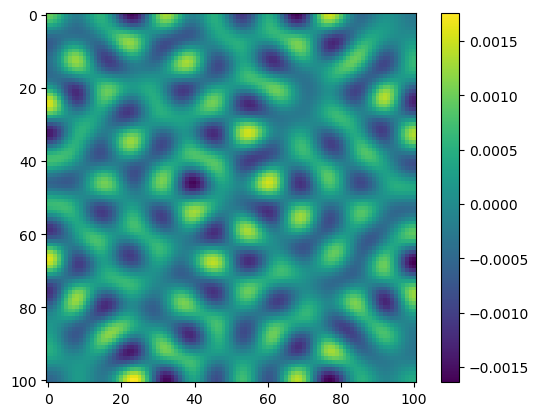

In [19]:
plt.imshow(Test_pred[41].reshape(101,101)-Ytest[41].reshape(101,101))
plt.colorbar()